<a href="https://colab.research.google.com/github/jecampagne/cours_mallat_cdf/blob/main/cours2023/gaussian_vs_turbulent_fow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install powerbox

In [2]:
import powerbox as pbox

In [3]:
import numpy as np
import scipy.stats as stats

import PIL
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 18

# Topic: non gaussianity of turbulent flow

Principle:
  - take a 2D tubulent flow image
  - compute its power spectrum P(k) via FFT
  - generate a gaussien field with the same P(k)

# Load the image of turbulent flow

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
import os
os.chdir("/content/drive/My Drive/Data4CoursSMallat")

In [12]:
ls

turbulence.png


In [13]:
imagePIL = Image.open('turbulence.png')
image = np.array(Image.open('turbulence.png').convert('L')) 

In [14]:
h,w = image.shape # heightxwidth
n = min(h,w)
d = np.log2(n)
npix = int(2**np.floor(d))
image = image[:npix,:npix]   # simple restriction to power 2 (FFT)

In [15]:
npix

512

In [16]:
image = image/npix**3 # normalisation

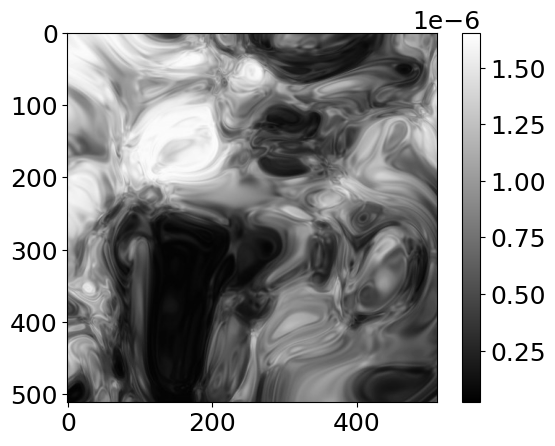

In [17]:
plt.imshow(image, plt.cm.gray), plt.colorbar();

# Compute image power spectrum

In [18]:
fourier_image = np.fft.fft2(image)
fourier_amplitudes = np.abs(fourier_image)**2

kfreq = np.fft.fftfreq(npix) * npix
kfreq2D = np.meshgrid(kfreq, kfreq)
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

knrm = knrm.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()

kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])
Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
#Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)


In [19]:
from scipy.interpolate import UnivariateSpline
pk_interp = UnivariateSpline(np.log10(kvals), np.log10(Abins))  # interpolate the P(k) in loglog


# Generation of a Gaussian field with the same P(k)

In [20]:
# Generate 
lnpb = pbox.PowerBox(
    N=npix,                    # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: 10**pk_interp(np.log10(k)),      # The power-spectrum
    boxlength = 1.0,           # Size of the box (sets the units of k in pk)
    seed = 1010                
)


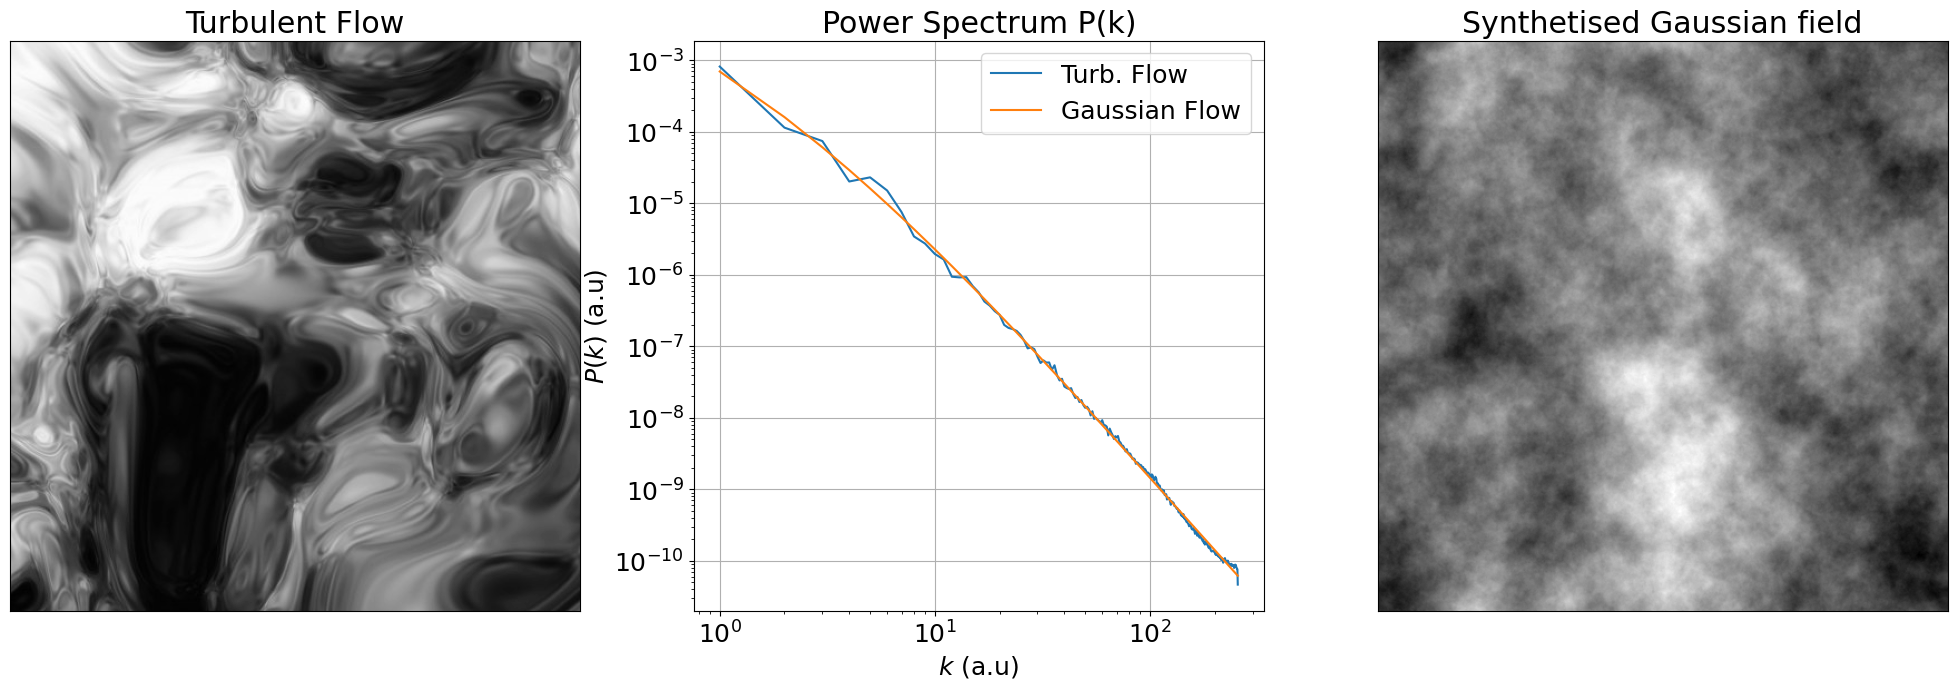

In [22]:
fig, axs = plt.subplots(1,3,figsize=(25,10))

axs[0].imshow(image,cmap='gray')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("Turbulent Flow")

axs[1].loglog(kvals, Abins,label='Turb. Flow')
axs[1].loglog(kvals,10**pk_interp(np.log10(kvals)), label='Gaussian Flow')
axs[1].set_xlabel("$k$ (a.u)")
axs[1].set_ylabel("$P(k)$ (a.u)")
dy=np.abs(np.log10(axs[1].get_ylim()[1])-np.log10(axs[1].get_ylim()[0]))
dx=np.abs(np.log10(axs[1].get_xlim()[1])-np.log10(axs[1].get_xlim()[0]))
golden_mean = 1#(np.sqrt(5)-1.0)/2.0
axs[1].set_aspect((dx/dy)*golden_mean,adjustable='box')
axs[1].legend()

axs[1].set_title("Power Spectrum P(k)")
axs[1].grid()

axs[2].imshow(lnpb.delta_x(),cmap='gray')
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Synthetised Gaussian field")
plt.show()

# Conclusion

The gaussian field with the same power spectrum as the turbulent flow, does not respect the geometry of the structures.